# Controllers

Optimal control solves the Markov decision process (MDP) for continuous spaces.  Sia uses finite horizon model predictive control (MPC), which is a practical runtime solution to accomplish this.  The objective is modeled as total cost $J(x, U)$ comprised of running $c_i$ and final costs $c_f$ for the sequence of actions $U = \{u_0, \ldots, u_{T-1}\}$

$$
J(x,U) = c_f(x_T) + \sum_{i=0}^{T-1} c_i(x_i,u_i)
$$

This cost structure is general enough to define a moving window cost around a trajectory.  The optimal controller finds the optimal sequence of actions $U$ from the current time to a horizon of $T$ steps into the future by solving

\begin{gather}
U^* = \arg\min_U~J(x, U) \\
\text{s.t.}~x_{k+1} = f(x_k, u_k)
\end{gather}

The first action $u_0$ in the sequence $U$ is applied to the system at the current time step.  Measurements are collected, state estimates are performed (if needed), and the optimal control problem is solved again on the next time step.

In Sia, cost functions inherit from the `sia.CostFunction` virtual base class which defines the generic cost structure above.  Concrete functional (differentiable) and quadratic cost specializations are provided.  Controllers inherit from the `sia.Controller` virtual base class which defines a generic `policy()` method to compute an action given the current state.  Sia includes several MPC algorithms, outlined in the table below.  Note that models in parenthesis are implicitly supported due to model inheritance.   Also note that both discrete time and continuous time model variants are supported.

| Controller | Optimal  | Supported costs                                 | Supported dynamics models                                                        |
| ---------- | -------- | ----------------------------------------------- |--------------------------------------------------------------------------------- |
| LQR        | Yes      | QuadraticCost                                   | LinearGaussianDynamics                                                           |
| iLQR       | No       | FunctionalCost, QuadraticCost               | LinearizableDynamics (NonlinearGaussianDynamics, LinearGaussianDynamics)         |
| MPPI       | No       | CostFunction, FunctionalCost, QuadraticCost | DynamicsModel (LinearizableDynamics, NonlinearGaussianDynamics, LinearGaussianDynamics) |

**References**

1. [M. Bohner and N. Wintz, The Linear Quadratic Tracker on Time Scales, Int. J. Dynamical Systems and Differential Equations, 2011.](https://web.mst.edu/~bohner/papers/tlqtots.pdf)

2. [Y. Tassa, T. Erez, and E. Todorov, Synthesis and Stabilization of Complex Behaviors through Online Trajectory Optimization, IEEE/RSJ IROS, 2012.](https://homes.cs.washington.edu/~todorov/papers/TassaIROS12.pdf)

3. [G. Williams et. al., Information Theoretic MPC for Model-Based Reinforcement Learning, IEEE ICRA, 2017.](https://homes.cs.washington.edu/~bboots/files/InformationTheoreticMPC.pdf)

In [1]:
# Import the libSIA python bindings and numpy
import pysia as sia
import numpy as np
import math

# Import plotting helpers
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# Set the generator instance seed for repeatability
generator = sia.Generator.instance()
generator.seed(10)

**Example**

We'll build controllers that collide two 2nd order moving particles $a$ and $b$ on a 2D plane.  Particle $a$ is controlled while particle $b$ is on a free trajectory.

$$
\begin{array}{cc}
\text{Particle a} & \text{Particle b} \\
\dot{v}_a = u,   & \dot{v}_b = 0 \\
\dot{x}_a = v_a, & \dot{x}_b = v_b
\end{array}
$$

We can represent this system with the linear state equations

$$
\begin{pmatrix}
\dot{v}_a \\
\dot{x}_a \\
\dot{v}_b \\
\dot{x}_b
\end{pmatrix} = \begin{pmatrix}
0 & 0 & 0 & 0 \\
I & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & I & 0
\end{pmatrix} \begin{pmatrix}
v_a \\
x_a \\
v_b \\
x_b
\end{pmatrix} + \begin{pmatrix}
1 \\
0 \\
0 \\
0 
\end{pmatrix} u
$$

We'll denote the state $x = (v_a,x_a,v_b,x_b)^\top$.  The objective of the controller is to drive the system to $x_a = x_b$ and $v_a = v_b$, i.e. $\min q_x \|x_a - x_b\|^2 + q_v \|v_a - v_b\|^2 + \|u\|^2$.  For the position portion of the cost, we can accomplish this by minimizing the quadratic

$$
\min q_x \begin{pmatrix}
x_a & x_b 
\end{pmatrix} \begin{pmatrix}
I & -I \\
-I & I
\end{pmatrix} \begin{pmatrix}
x_a \\ x_b 
\end{pmatrix}
$$

We can apply a similar quadratic matrix factorization for the velocity portion of the cost.  We'll leave the input cost at $r=1$ so that the state costs are relative to the input.

In [2]:
# System
dt = 0.1
A = np.zeros((8, 8))
A[2:4,0:2] = np.eye(2)
A[6:8,4:6] = np.eye(2)
B = np.zeros((8, 2))
B[0:2,0:2] = np.eye(2)
I = np.eye(8)
system = sia.LinearGaussianDynamicsCT(A, B, I, dt)

# Cost
qx = 50  # Position
qv = 10  # Velocity

# Create the cost matrices
Q = np.zeros((8, 8))
Q[2:4,2:4] = np.eye(2) * qx
Q[2:4,6:8] = -np.eye(2) * qx
Q[6:8,2:4] = -np.eye(2) * qx
Q[6:8,6:8] = np.eye(2) * qx
Q[0:2,0:2] = np.eye(2) * qv
Q[0:2,4:6] = -np.eye(2) * qv
Q[4:6,0:2] = -np.eye(2) * qv
Q[4:6,4:6] = np.eye(2) * qv
Qf = Q
R = np.eye(2)

# Create the cost function
cost = sia.QuadraticCost(Qf, Q, R)

## Linear Quadratic Regulator (LQR)

LQR solves the optimal control problem for a linear system $x_{k+1} = F x_k + G u_k$ and quadratic cost.  It the control analog to the Kalman Filter estimator.

$$
J = \frac{1}{2} (x_T-x^*_T)^\top Q_f (x_T-x^*_T) + \sum_{i=0}^{T-1} (x_i-x^*_i)^\top Q (x_i-x^*_i) + u_i^\top R u_i
$$

1. In the **backward recursion**, the terminal cost is used to initialize the value function gradient $v_T = Q_f x^*_T$ and Hessian $P_T = Q_f$.  The Hessian of the state-action value function is computed first.

\begin{gather}
Q_{uu}^{-1} = \left(R + G^\top P_{i+1} G\right)^{-1}
\end{gather}

&emsp;&emsp;The feedback and feedforward gains $K,k$ are then computed.

\begin{gather}
K_i = Q_{uu}^{-1} G^\top P_{i+1} F \\
k_i = Q_{uu}^{-1} G^\top v_{i+1}
\end{gather}

&emsp;&emsp;The value function gradient $v$ and Hessian $P$ are back propogated using the Riccati equations.

\begin{gather}
P_i = F^\top P_{i+1} \left(F - G K_i\right) + Q \\
v_i = \left(F - G K_i\right)^\top v_{i+1} + Q_f x^*_i
\end{gather}

2. In the **forward recursion**, the action and next state are computed.

\begin{gather}
u_i = - K_i x_i + k_i \\
x_{i+1} = F x_i + G u_i
\end{gather}

**Tuning.** The tuning parameters with LQR are the cost matrices $Q_f, Q, R$ and the horizon $T$.  Increasing the state cost $Q_f, Q$ vs action cost $R$ reduces tracking error at the expense of higher amplitude actions.  The horizon $T$ is chosen to trade off computation time versus the ability to anticipate future dynamics.

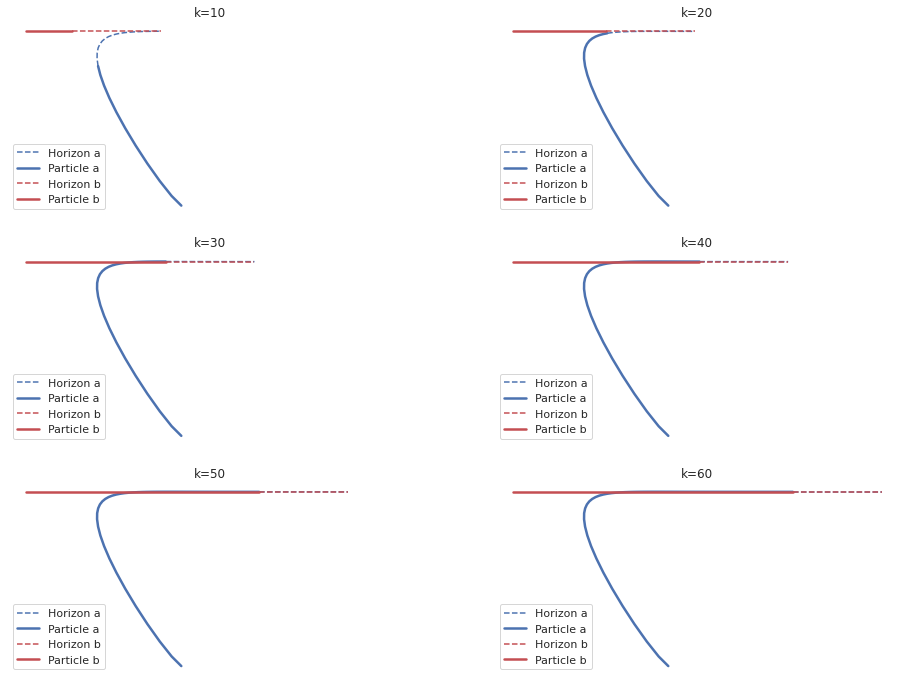

In [3]:
# Initialize the controller
horizon = 20
lqr = sia.LQR(system, cost, horizon)

# Initialize the system states
n = 70
u = np.zeros((2, n))
x = np.zeros((8, n))
x[:, 0] = np.array([-3, 0, 10, 0, 3, 0, 0, 8])
s = sia.Gaussian(8)

# Run the system for n steps
f, ax = plt.subplots(3, 2, figsize=(16, 12), sharex=True, sharey=True)
ax = ax.flatten()
sns.despine(f, left=True, bottom=True)
c = 0
for k in range(0, n-1):
    s.setMean(x[:, k])
    u[:, k] = lqr.policy(s)
    
    # Plot the system at several time slices
    if math.fmod(k, 10) == 0 and k > 0:
        states = np.array(lqr.states()).T
        ax[c].plot(states[2, :], states[3, :], '--b', lw=1.5, label="Horizon a")
        ax[c].plot(x[2, :k+1], x[3, :k+1], '-b', lw=2.5, label="Particle a")
        ax[c].plot(states[6, :], states[7, :], '--r', lw=1.5, label="Horizon b")
        ax[c].plot(x[6, :k+1], x[7, :k+1], '-r', lw=2.5, label="Particle b")
        ax[c].set_title("k={}".format(k))
        ax[c].legend(loc="lower left")
        ax[c].axis("off")
        c += 1
    
    x[:, k+1] = system.f(x[:, k], u[:, k])

## Iterative Linear Quadratic Regulator (iLQR)

iLQR uses a local linearization to iteratively solve the nonlinear optimal control problem using LQR for a differentiable nonlinear system $x_{k+1} = f(x_k, u_k)$ and nonlinear cost.  iLQR is the control analog to the EKF estimator.

$$
J = c_f(x_T) + \sum_{i=0}^{T-1} c_i(x_i,u_i)
$$

iLQR makes use of the local Jacobians and Hessians of the cost and dynamics, which we'll abbreviate for simplicity

\begin{gather}
c_x = \frac{\delta c_i}{\delta x_i},~c_u = \frac{\delta c_i}{\delta u_i},~c_{xx} = \frac{\delta^2c_i}{\delta x^2_i},~c_{uu} = \frac{\delta^2c_i}{\delta u^2_i},~c_{ux} = \frac{\delta^2c_i}{\delta x_i \delta u_i} \\
f_x = \frac{\delta f}{\delta x_i},~f_u = \frac{\delta f}{\delta u_i}
\end{gather}

The following iterative procedure repeats until convergence.  The procedure is initialized with a guess for the actions $U =\{u_0,\dots,u_{T-1}\}$ and corresponding states $X$ by integrating the nonlinear dynamics forward in time.

1. In the **backward recursion**, the terminal cost $c_f$ and the estimated final state $x_T$ are used to initialize the value function gradient $V_x' = c_x(x_T)$ and Hessian $V_{xx}' = c_{xx}(x_T)$.  We denote prime as the next step, i.e. $V' = V_{i+1}$.  The terms for the local quadratic approximation of the value function recursion are computed first.  A regularization $\mu$ around the state is added to keep $Q_{uu}$ positive definite.

\begin{gather}
Q_x = c_x + f_x^\top V_x' \\
Q_u = c_u + f_u^\top V_x' \\
Q_{xx} = c_{xx} + f_x^\top V_{xx}' f_x \\
Q_{uu} = c_{uu} + f_u^\top (V_{xx}' + \mu I) f_u \\
Q_{ux} = c_{ux} + f_u^\top (V_{xx}' + \mu I) f_x
\end{gather}

&emsp;&emsp;The feedback and feedforward gains $K,k$ are then computed from the local quadratic value function approximation.

\begin{gather}
K = -Q_{uu}^{-1} Q_{ux} \\
k = -Q_{uu}^{-1} Q_u
\end{gather}

&emsp;&emsp;The value function gradient $V_x$ and Hessian $V_{xx}$ are back propogated for the next step of the recursion.

\begin{gather}
V_x = Q_x + K^\top (Q_{uu} k + Q_u) + Q_{ux}^\top k \\
V_{xx} = Q_{xx} + K^\top (Q_{uu} K + Q_{ux}) + Q_{ux}^\top K 
\end{gather}

&emsp;&emsp;We also keep track the of portions of the change in cost ($\Delta J = \Delta J_a + \Delta J_b$).  This is used later to check for convergence and also in the forward recursion.

\begin{gather}
\Delta J_a \mathrel{{+}{=}} k^\top Q_u \\
\Delta J_b \mathrel{{+}{=}} \frac{1}{2} k^\top Q_{uu} k
\end{gather}

2. In the **forward recursion**, the a modified state $\hat{x}$ and action $\hat{u}$ are computed from the original states $x$ and actions $u$ found in the previous iteration (or the initial warm start mentioned above if it is the first iteration).

\begin{gather}
\hat{x}_0 = x_0 \\
\hat{u}_i = u_i + \alpha k_i + K_i (\hat{x}_i - x_i) \\
\hat{x}_{i+1} = f(\hat{x}_i, \hat{u}_i)
\end{gather}

&emsp;&emsp;For general nonlinear systems, a new trajectory can stray too far from the model's region of validity and result in cost divergence.  We introduced a backtracking line search parameter $0 < \alpha \leq 1$ above to address this issue.  Starting with $\alpha=1$, the forward recursion is iterated until $0 < z_{min} < z$ or a max number of backstepping iterations is exceeded, where $z$ is defined

\begin{gather}
\Delta J(\alpha) = \alpha (\Delta J_a + \alpha \Delta J_b) \\
z = \frac{J(U) - J(\hat{U})}{\Delta J(\alpha)}
\end{gather}

The main iteration of 1) and 2) terminates when the change in cost $dJ < \epsilon$ or a maximum number of iterations is exceeded.  With each new call to the iLQR policy, the previous actions $U$ are shifted forward one step in time, which warm starts the next iteration from the previous solution.

**Tuning.** As with LQR, the cost and horizon $T$ are obvious tuning parameters with similar effects.  The addition parameters used in iLQR are

- $\epsilon > 0$.  Convergence threshold.  The algorithm iteration terminates when the change in cost $\Delta J < \epsilon$.

- $\mu > 0$. Regularization parameter added to ensure $Q_{uu}$ is positive definite.  Increase if warnings are logged.

- $1 > \tau > 0$. Shrink rate factor on $\alpha$ during backstepping, i.e. $\alpha \leftarrow \tau \alpha$.  Increase if backstepping takes too many iterations.

- $z_{min} > 0$. Minimum threshold on $\Delta J$ to accept the backstepping iteration.  Increase if faster convergence is needed.

- *max_iter*.  Defines the maximum number of iterations allowed for the entire backward pass, forward pass iteration.  Included as a safety to keep the algorithm from running forever, increase if iterations are being exceeded.

- *max_backsteps*.  Defines the maximum number of iterations allowed for the backstepping in the forward pass.  Included as a safety to keep the backstepping from running forever, increase if iterations are being exceeded.

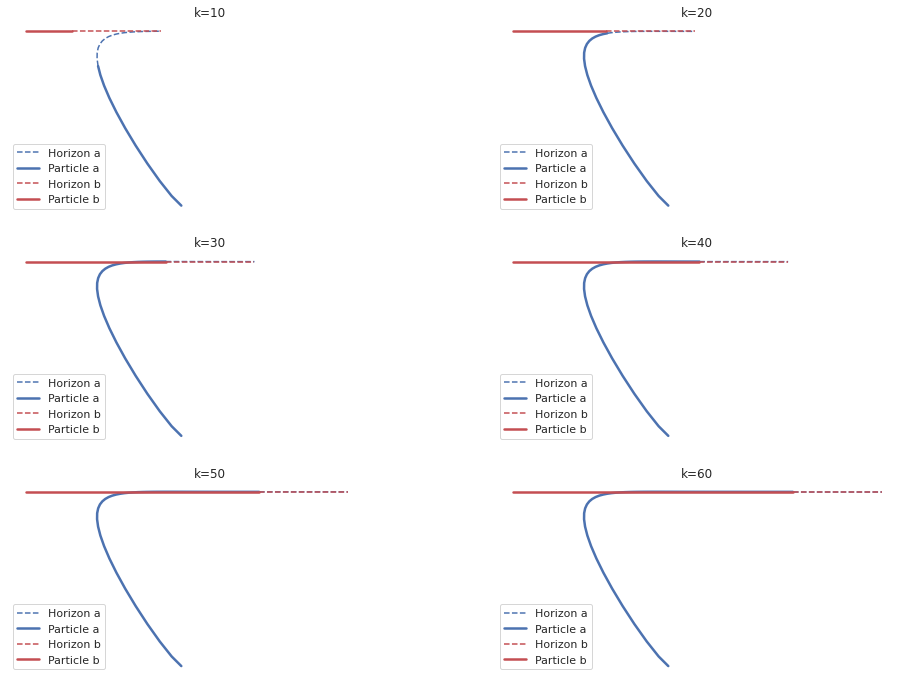

In [4]:
# Initialize the controller
horizon = 20
u0 = [np.array([0, 0]) for i in range(horizon)]
options = sia.iLQR.Options()
options.max_lqr_iter = 10
options.max_linesearch_iter = 10
ilqr = sia.iLQR(system, cost, u0, options=options)

# Initialize the system states
n = 70
u = np.zeros((2, n))
x = np.zeros((8, n))
x[:, 0] = np.array([-3, 0, 10, 0, 3, 0, 0, 8])
s = sia.Gaussian(8)

# Run the system for n steps
f, ax = plt.subplots(3, 2, figsize=(16, 12), sharex=True, sharey=True)
ax = ax.flatten()
sns.despine(f, left=True, bottom=True)
c = 0
for k in range(0, n-1):
    s.setMean(x[:, k])
    u[:, k] = ilqr.policy(s)
    
    # Plot the system at several time slices
    if math.fmod(k, 10) == 0 and k > 0:
        states = np.array(ilqr.states()).T
        ax[c].plot(states[2, :], states[3, :], '--b', lw=1.5, label="Horizon a")
        ax[c].plot(x[2, :k+1], x[3, :k+1], '-b', lw=2.5, label="Particle a")
        ax[c].plot(states[6, :], states[7, :], '--r', lw=1.5, label="Horizon b")
        ax[c].plot(x[6, :k+1], x[7, :k+1], '-r', lw=2.5, label="Particle b")
        ax[c].set_title("k={}".format(k))
        ax[c].legend(loc="lower left")
        ax[c].axis("off")
        c += 1
    
    x[:, k+1] = system.f(x[:, k], u[:, k])

## Model Predictive Path Integrals (MPPI)

MPPI uses a sampling-based strategy to solve the MPC problem, which makes it applicable to general dynamics.  This generality comes at the expense of additional computation needed to deal with Monte Carlo rollouts.  MPPI samples controls forward in time from the current state, weights each trajectory by the associated cost, and finds the optimal trajectory as the weighted average of the sampled trajectories.  MPPI is the control analog to the Particle Filter estimator.

In Sia, MPPI solves the MPC problem for general dynamics $p(x_{k+1} | x_k, u_k)$ and a general cost function.  The original paper does not include actions as inputs to the cost formulation but the algorithm yields good results when it is included.

$$
J = c_f(x_T) + \sum_{i=0}^{T-1} c_i(x_i,u_i)
$$

The procedure is initialized with a guess for the actions $U =\{u_0,\dots,u_{T-1}\}$.

1. In the **sampling rollout**, $j = \{1,\ldots,N\}$ trajectories of proposal actions are sampled.  The proposals are generated by sampling perturbations $\epsilon$ around the nominal control $U$.  The $j^\text{th}$ proposal trajectory is computed as follows by integrating the dynamics forward for $T-1$ iterations.  The path integral cost is stored in $S$.

\begin{gather}
x_0^{(j)} = x_0,~S^{(j)}=0 \\
\epsilon_i^{(j)} \sim \mathcal{N}(0, \Sigma) \\
u_i^{(j)} = u_i + \epsilon_i^{(j)} \\
S^{(j)} \mathrel{{+}{=}} c_i(x_i^{(j)}, u_i^{(j)}) + \lambda u_i^{{(j)}\top } \Sigma^{-1} \epsilon_i^{(j)} \\
x_{i+1}^{(j)} = \mathbb{E}[p(x_{i+1} | x_i^{(j)}, u_i^{(j)})]
\end{gather}

&emsp;&emsp;At the end of each trajectory rollout, the final cost of the state is appended to the path integral cost for the rollout

$$
S^{(j)} \mathrel{{+}{=}} c_f(x_T)
$$

2. In the **weighting** step, weights are computed for each trajectory based on the path integral cost.

\begin{gather}
\beta \leftarrow \min_j ~\{S^{(j)}\} \\
w^{(j)} = \exp \left( -\frac{1}{\lambda}\left(S^{(j)} - \beta\right)\right) \\
w^{(j)} \leftarrow \frac{w^{(j)}}{\sum_j w^{(j)}}
\end{gather}

3. In the final **action averaging** step, the new actions are computed based on the weighted combination of perturbations $\epsilon$ rollout trajectories

\begin{gather}
\hat{x}_0 = x_0 \\
\hat{u}_i = \sum_j w^{(j)} \epsilon_i^{(j)} \\
\hat{x}_{i+1} = f(\hat{x}_i, \hat{u}_i)
\end{gather}

With each new call to the MPPI policy, the previous actions $U$ are shifted forward one step in time, which warm starts the next iteration from the previous solution.

**Tuning.** As with LQR and iLQR, the cost and horizon $T$ are obvious tuning parameters with similar effects.  The addition parameters used in MPPI are

- $\Sigma > 0$.  Action perturbation sampling covariance.  Increasing this covariance matrix will increase exploration at the expense of noisier trajectories.

- $\lambda > 0$.  Penalty on action perturbation.  A higher value will increase the penalty of deviations from the nominal action, biasing the new actions more toward the previous ones.  This effectively adds damping on the action update.  Increase if the rollout trajectories between each MPC policy call vary too much, decrease if the algorithm needs to adjust quickly, e.g. if the process noise in the dynamics model is high.

- $N \geq 1$.  Number of samples.  More samples will yield more optimal solutions at the expense of added computation time.

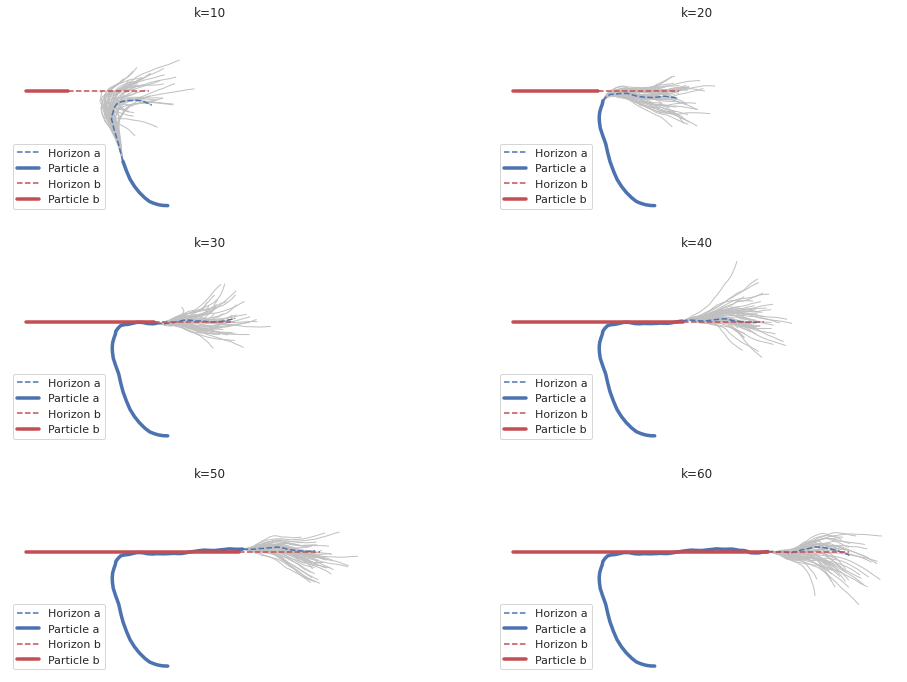

In [5]:
# Initialize the controller
horizon = 20
u0 = [np.array([0, 0]) for i in range(horizon)]
options = sia.MPPI.Options()
options.num_samples = 50
options.temperature = 1e-2
mppi = sia.MPPI(system, cost, u0, sample_covariance=np.diag([5, 5]), options=options)

# Initialize the system states
n = 70
u = np.zeros((2, n))
x = np.zeros((8, n))
x[:, 0] = np.array([-3, 0, 10, 0, 3, 0, 0, 8])
s = sia.Gaussian(8)

# Run the system for n steps
f, ax = plt.subplots(3, 2, figsize=(16, 12), sharex=True, sharey=True)
ax = ax.flatten()
sns.despine(f, left=True, bottom=True)
c = 0
for k in range(0, n-1):
    s.setMean(x[:, k])
    u[:, k] = mppi.policy(s)
    
    # Plot the system at several time slices
    if math.fmod(k, 10) == 0 and k > 0:
        states = np.array(mppi.states()).T
        X = mppi.rolloutStates()
        w = mppi.rolloutWeights()
        for i in range(len(w)):
            xx = np.array(X[i]).T
            ax[c].plot(xx[2, :], xx[3, :], c="silver", lw=1)
        ax[c].plot(states[2, :], states[3, :], '--b', lw=1.5, label="Horizon a")
        ax[c].plot(x[2, :k+1], x[3, :k+1], '-b', lw=3.5, label="Particle a")
        ax[c].plot(states[6, :], states[7, :], '--r', lw=1.5, label="Horizon b")
        ax[c].plot(x[6, :k+1], x[7, :k+1], '-r', lw=3.5, label="Particle b")
        ax[c].set_title("k={}".format(k))
        ax[c].legend(loc="lower left")
        ax[c].axis("off")
        c += 1
    
    x[:, k+1] = system.f(x[:, k], u[:, k])